Working Perfectly fine. Using bert based model to detect fake news with 85 % accuracy.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [3]:
!ls "/content/drive/My Drive/News"

Fake.csv  True.csv


In [4]:
real = pd.read_csv("/content/drive/My Drive/News/True.csv")
fake = pd.read_csv("/content/drive/My Drive/News/Fake.csv")

In [5]:
#Displayed the first 5 rows of the real news dataset
real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [6]:
#Displayed the first 5 rows of the fake news dataset
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [7]:
#Shape of real news dataset
print("Real news: ",real.shape)
#Shape of fake news dataset
print("Fake News: ", fake.shape)

Real news:  (21417, 4)
Fake News:  (23481, 4)


In [8]:
#Assigning a value of 0 for all real news data and placing it in the dataframe
class0 = []

for i in range(21417):
  class0.append(0)

real.insert(4, "class", class0, True)

In [9]:
#Assigning a value of 1 for all fake news data and placing it in the dataframe
class1 = []

for i in range(23481):
  class1.append(1)

fake.insert(4, "class", class1, True)

In [10]:
#Concactenating fake news and real news into 1 total dataset
total = pd.concat([real,fake])
total = total.sample(frac = 1)

In [11]:
#Shape of total
total.shape

(44898, 5)

In [12]:
#total = total.sample(frac=1)
pd.set_option('display.width', total.shape[0])
total.head()


,title,text,subject,date,class
9929,John Kerry: Carnival should not bar Cuban-Amer...,MIAMI (Reuters) - U.S. Secretary of State John...,politicsNews,"April 14, 2016",0
940,Trump’s Plan To Quietly Sneak Into England Ba...,White House officials are now saying Trump won...,News,"July 3, 2017",1
12931,Greek police fire teargas at protesters on ann...,ATHENS (Reuters) - Greek police fired teargas ...,worldnews,"December 6, 2017",0
19105,"After German election, Macron to set out his v...",PARIS (Reuters) - French President Emmanuel Ma...,worldnews,"September 25, 2017",0
13036,JUDGE JEANINE Delivers EPIC Hillary Slap Down:...,YIKES That s gonna leave a mark!,politics,"Sep 11, 2016",1


In [13]:
#Extract only the values for title (input) and class (output)
data = total[['title','class']]
data.head()


,title,class
9929,John Kerry: Carnival should not bar Cuban-Amer...,0
940,Trump’s Plan To Quietly Sneak Into England Ba...,1
12931,Greek police fire teargas at protesters on ann...,0
19105,"After German election, Macron to set out his v...",0
13036,JUDGE JEANINE Delivers EPIC Hillary Slap Down:...,1


In [14]:
# Character Length of Titles - Min, Mean, Max
print('Mean Length', data['title'].apply(len).mean())
print('Min Length', data['title'].apply(len).min())
print('Max Length', data['title'].apply(len).max())



Mean Length 80.11171989843646
Min Length 8
Max Length 286


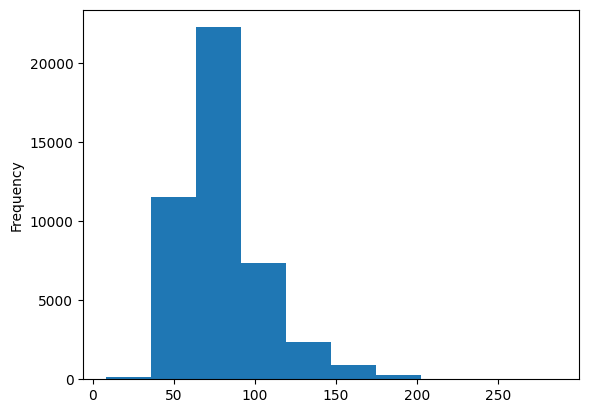

In [15]:
#plotting the frequency of characters on a histogram
import seaborn as sns

x = data['title'].apply(len).plot.hist()

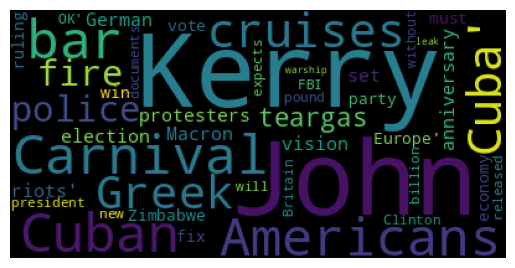

In [16]:
#Word cloud of most common words from real news
#For fake news, change ["class"] == 0 to 1
from wordcloud import WordCloud, STOPWORDS

#Note to self: fix for entire dataset
text = data[data["class"] == 0].values
wc = WordCloud(stopwords=STOPWORDS).generate(str(text))
plt.imshow(wc)
plt.axis("off")
plt.show()

In [17]:
#Extracting numpy arrays for the title and classes
titles = data["title"].values
labels = data["class"].values



In [18]:
from sklearn.model_selection import train_test_split

#Split data into training and testing dataset
#We teach our model based on the training set (including the labels)
#We take the labels away to test our model with the testing set
title_train, title_test, y_train, y_test = train_test_split(titles, labels, test_size=0.2, random_state=1000)



In [19]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text


In [20]:
#Download bert preprocesser and bert encoder from tensorflow_hub
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

In [21]:
def get_bert_embeddings(text_list):
    """
    text_list: list / numpy array / pandas Series of strings
    returns: NumPy array of shape (batch_size, 768)
    """
    # Convert input texts to a real Tensor (NOT a Keras Input)
    text_tensor = tf.constant(text_list, dtype=tf.string)
    processed = bert_preprocess(text_tensor)
    outputs = bert_encoder(processed)
    pooled = outputs["pooled_output"]   # shape: (batch_size, 768)
    return pooled.numpy().astype("float32")


In [22]:
import numpy as np
import math
import tensorflow as tf

def get_bert_embeddings_batched(text_list, batch_size=64):
    all_embeds = []
    n = len(text_list)
    num_batches = math.ceil(n / batch_size)

    for b in range(num_batches):
        batch = text_list[b*batch_size : (b+1)*batch_size]

        text_tensor = tf.constant(batch, dtype=tf.string)

        # Send BERT ops to GPU
        with tf.device("/GPU:0"):
            processed = bert_preprocess(text_tensor)
            outputs = bert_encoder(processed)
            pooled = outputs["pooled_output"]

        all_embeds.append(pooled.numpy())

        print(f"Batch {b+1}/{num_batches} done...")

    return np.vstack(all_embeds)


In [23]:
# Convert titles/headlines to plain lists (if they are pandas Series)
X_train_text = list(title_train)
X_test_text  = list(title_test)

# Get BERT embeddings
X_train_embed = get_bert_embeddings_batched(X_train_text, batch_size=64)
X_test_embed  = get_bert_embeddings_batched(X_test_text,  batch_size=64)

print("Train embeddings shape:", X_train_embed.shape)
print("Test embeddings shape:", X_test_embed.shape)



Batch 1/562 done...
Batch 2/562 done...
Batch 3/562 done...
Batch 4/562 done...
Batch 5/562 done...
Batch 6/562 done...
Batch 7/562 done...
Batch 8/562 done...
Batch 9/562 done...
Batch 10/562 done...
Batch 11/562 done...
Batch 12/562 done...
Batch 13/562 done...
Batch 14/562 done...
Batch 15/562 done...
Batch 16/562 done...
Batch 17/562 done...
Batch 18/562 done...
Batch 19/562 done...
Batch 20/562 done...
Batch 21/562 done...
Batch 22/562 done...
Batch 23/562 done...
Batch 24/562 done...
Batch 25/562 done...
Batch 26/562 done...
Batch 27/562 done...
Batch 28/562 done...
Batch 29/562 done...
Batch 30/562 done...
Batch 31/562 done...
Batch 32/562 done...
Batch 33/562 done...
Batch 34/562 done...
Batch 35/562 done...
Batch 36/562 done...
Batch 37/562 done...
Batch 38/562 done...
Batch 39/562 done...
Batch 40/562 done...
Batch 41/562 done...
Batch 42/562 done...
Batch 43/562 done...
Batch 44/562 done...
Batch 45/562 done...
Batch 46/562 done...
Batch 47/562 done...
Batch 48/562 done...
B

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Initialize the Sklearn Logistic Regression Classifier
# solver='lbfgs' is standard; max_iter=1000 ensures it converges on high-dim data
sklearn_model = LogisticRegression(C=1.0, solver='lbfgs', max_iter=1000)

print("Training Sklearn Logistic Regression...")

# Train the model on the BERT embeddings we already generated
sklearn_model.fit(X_train_embed, y_train)

# Evaluate on the test set
y_pred = sklearn_model.predict(X_test_embed)

print("------------------------------------------------")
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("------------------------------------------------")
print(classification_report(y_test, y_pred))

Training Sklearn Logistic Regression...
------------------------------------------------
Test Accuracy: 0.9515590200445434
------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      4298
           1       0.96      0.95      0.95      4682

    accuracy                           0.95      8980
   macro avg       0.95      0.95      0.95      8980
weighted avg       0.95      0.95      0.95      8980



In [26]:
import joblib

# Save the sklearn model to a file
# Note: We name it 'bert_sklearn.pkl' to distinguish it
joblib.dump(sklearn_model, 'bert_sklearn.pkl')

print("Model saved as bert_sklearn.pkl")

Model saved as bert_sklearn.pkl


In [27]:
def predict_news_sklearn(headlines):
    # Allow single string or list of strings
    if isinstance(headlines, str):
        headlines = [headlines]

    # 1. Get embeddings (Reuse your existing function)
    embeds = get_bert_embeddings_batched(headlines, batch_size=32)

    # 2. Model prediction
    # predict_proba returns [[prob_0, prob_1], ...]
    # We want column 1 (Probability of being 'Real')
    probs = sklearn_model.predict_proba(embeds)[:, 1]

    results = []
    for text, p in zip(headlines, probs):
        # p is already a float between 0 and 1

        # Decision Boundary
        label = "REAL" if p >= 0.5 else "FAKE"

        # Confidence score (distance from 0.5)
        confidence = p if label == "REAL" else (1 - p)

        results.append({
            "headline": text,
            "prediction": label,
            "confidence": round(confidence, 4)
        })

    return results

# Test it immediately
print(predict_news_sklearn("CD exam got cancelled."))

Batch 1/1 done...
[{'headline': 'CD exam got cancelled.', 'prediction': 'FAKE', 'confidence': np.float64(0.9123)}]


In [29]:
!pip install huggingface_hub
from huggingface_hub import notebook_login

notebook_login()


In [30]:
from huggingface_hub import HfApi

api = HfApi()

# Ensure you are logged in via notebook_login() before running this
api.upload_file(
    path_or_fileobj="bert_sklearn.pkl",  # The new file we just saved
    path_in_repo="bert_sklearn.pkl",     # Name in the repository
    repo_id="DarkKnight001/sklearn-detection-bert-model"
)

print("Sklearn model uploaded successfully!")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  bert_sklearn.pkl            : 100%|##########| 7.01kB / 7.01kB            

Sklearn model uploaded successfully!


In [ ]:
from huggingface_hub import HfApi

api = HfApi()

# Ensure you are logged in via notebook_login() before running this
api.upload_file(
    path_or_fileobj="bert_sklearn.pkl",  # The new file we just saved
    path_in_repo="bert_sklearn.pkl",     # Name in the repository
    repo_id="DarkKnight001/sklearn-detection-bert-model"
)

print("Sklearn model uploaded successfully!")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  bert_sklearn.pkl            : 100%|##########| 7.01kB / 7.01kB            

Sklearn model uploaded successfully!


In [31]:
!pip install flask flask-ngrok
!pip install tensorflow tensorflow_text
!pip install transformers
!pip install pyngrok
!pip install gensim
!pip install tensorflow tensorflow_hub tensorflow_text joblib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 86.1 MB/s eta 0:00:00


In [32]:
from pyngrok import ngrok
ngrok.set_auth_token("35dbBpjUOl9yP3NcpAPOe6BV3jV_6uYH5enpVmCC8m9a9sDhm")


In [33]:
public_url = ngrok.connect(5000)
print(public_url)
!python app.py


NgrokTunnel: "https://chordamesodermal-commentatorial-nicolette.ngrok-free.dev" -> "http://localhost:5000"
2025-12-12 06:40:00.307195: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765521600.341372    7975 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765521600.351071    7975 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765521600.376588    7975 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765521600.376624    7975 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same tar